In [1]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
import scipy.io
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

# Reading data

In [7]:
mat = scipy.io.loadmat('/Users/hasan/Desktop/Anaconda/Research/mixoutALL_shifted.mat')

s = set()
for i in range(len(mat['mixout'][0])):
    s.add(mat['mixout'][0][i].shape[1])
print("length of data points belongs to: \n", s)

labels = mat['consts'][0][0][4][0]
print(labels)

Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data, dtype='object')
print(Data.shape)


data = [0] * 20
for i in range(1, 21):
    I = np.where(labels == i)[0]
    data[i-1] = Data[I]
data = np.array(data, dtype='object')

length of data points belongs to: 
 {160, 130, 162, 163, 196, 198, 166, 109, 174, 205, 176, 177, 178, 173, 183, 152}
[ 1  1  1 ... 20 20 20]
(2858,)


In [8]:
mat = scipy.io.loadmat('/Users/hasan/Desktop/Anaconda/Research/mixoutALL_shifted.mat')

s = set()
for i in range(len(mat['mixout'][0])):
    s.add(mat['mixout'][0][i].shape[1])
print("length of data points belongs to: \n", s)

length of data points belongs to: 
 {160, 130, 162, 163, 196, 198, 166, 109, 174, 205, 176, 177, 178, 173, 183, 152}


In [9]:
labels = mat['consts'][0][0][4][0]
labels

array([ 1,  1,  1, ..., 20, 20, 20], dtype=uint8)

In [10]:
Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data)
Data.shape

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


(2858,)

In [11]:
data = [0] * 20
for i in range(1, 21):
    I = np.where(labels == i)[0]
    data[i-1] = Data[I]
data = np.array(data, dtype='object')

# Chosen Pairs

In [12]:
pairs = [[16,18], [10,18], [10,16], [2,8], [3,11]]
pairs = np.array(pairs) - 1
# (u,w), (n,w), (n,u), (b,c), (c,o)

In [13]:
for n, m in pairs:
    print(len(data[m]), len(data[n]))

125 131
125 130
131 130
174 141
141 142


In [17]:
for n, m in pairs:
    print("len(data[m]), len(data[n]):", len(data[m]), len(data[n]))
    min_x, min_y = np.min((np.min([np.min(data[m][i], axis=0) for i in range(len(data[m]))], axis=0), 
           np.min([np.min(data[n][i], axis=0) for i in range(len(data[n]))], axis=0)), axis=0)

    max_x, max_y = np.max((np.max([np.max(data[m][i], axis=0) for i in range(len(data[m]))], axis=0), 
                   np.max([np.max(data[n][i], axis=0) for i in range(len(data[n]))], axis=0)), axis=0)

    print("length and width:", np.round(max_x - min_x, decimals=2), 
          np.round(max_y - min_y, decimals=2))
    print()

len(data[m]), len(data[n]): 125 131
length and width: 112.63 80.55

len(data[m]), len(data[n]): 125 130
length and width: 121.38 87.84

len(data[m]), len(data[n]): 131 130
length and width: 124.82 84.34

len(data[m]), len(data[n]): 174 141
length and width: 83.11 82.55

len(data[m]), len(data[n]): 141 142
length and width: 98.75 61.08



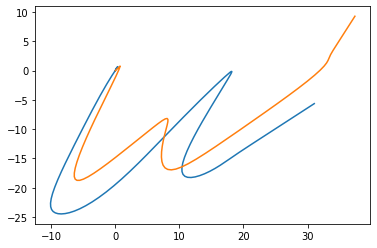

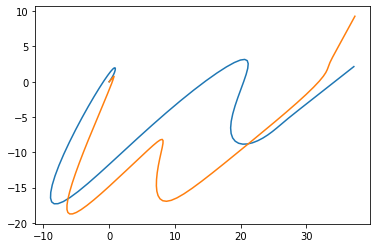

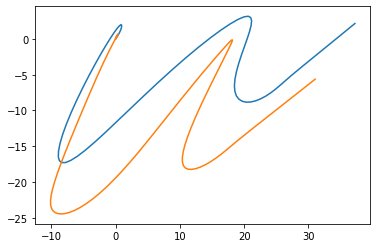

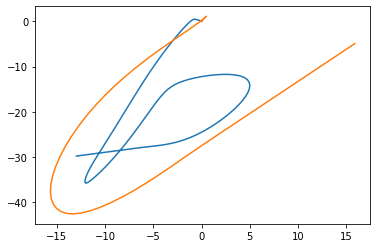

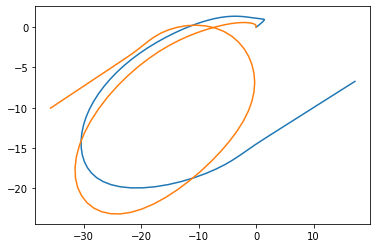

In [10]:
for n, m in pairs:
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

# KNN with Soft-DTW with matrix saving method

In [18]:
def calculate_dists_soft_dtw(data1, data2, gamma, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            D = SquaredEuclidean(data[i], data[j])
            sdtw = SoftDTW(D, gamma=gamma)
            A.append(sdtw.compute())
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')
    total_time = time.time() - start_time
    return total_time

In [19]:
paths = []
for i in range(len(pairs)):
    paths.append('/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN/Characters-Pairs['+str(i)+']-soft-dtw.csv')

for i in range(len(pairs)):
    calculate_dists_soft_dtw(data[pairs[i][0]], data[pairs[i][1]], gamma=0.1, path=paths[i])

In [20]:
def KNN_with_dists_soft_dtw(n_1, n_2, path_to_dists):
    '''path example: path = '/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN/Characters-Pairs['+str(i)+']-soft-dtw.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [21]:
def KNN_average_error_soft_dtw(data1, data2, num_trials, path_to_dists, pair):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_soft_dtw(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with soft-dtw for pairs {pair}", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [22]:
paths = []
for i in range(len(pairs)):
    paths.append('/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN/Characters-Pairs['+str(i)+']-soft-dtw.csv')

for i in range(len(pairs)):
    print(KNN_average_error_soft_dtw(data[pairs[i][0]], data[pairs[i][1]], 
                                        num_trials=50, path_to_dists=paths[i], 
                                        pair=pairs[i])[0])
    print("=======================================================================")

num_trials = 50
total time = 1.63663911819458
                            Classifier  Train Error  Test Error     std
1  KNN with soft-dtw for pairs [15 17]        0.061      0.0967  0.0263
num_trials = 50
total time = 1.563049077987671
                            Classifier  Train Error  Test Error    std
1  KNN with soft-dtw for pairs [ 9 17]       0.1237      0.2156  0.038
num_trials = 50
total time = 1.594510793685913
                            Classifier  Train Error  Test Error     std
1  KNN with soft-dtw for pairs [ 9 15]       0.0368      0.0623  0.0235
num_trials = 50
total time = 2.100154161453247
                          Classifier  Train Error  Test Error     std
1  KNN with soft-dtw for pairs [1 7]       0.0002      0.0029  0.0063
num_trials = 50
total time = 1.7409651279449463
                            Classifier  Train Error  Test Error     std
1  KNN with soft-dtw for pairs [ 2 10]          0.0      0.0002  0.0016
